In [1]:
import time

import torch
import torch.nn as nn
from anyio import sleep
from numba.cuda.printimpl import print_item
from numpy import character
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
from newton import riemann_solver_newton

import numpy as np
import pandas as pd

In [ ]:
def generate_training_data(riemann_solver_newton, num_samples=1000,
                           h_min=0.01, h_max=10.0,
                           hu_min=-10.0, hu_max=10.0):
    """
    Generate training samples for a neural network using a Riemann solver.

    Parameters:
        riemann_solver_newton: function
            The Riemann solver function that computes (h*, u*) given (hL, huL, hR, huR).
        num_samples: int
            Number of samples to generate.
        h_min: float
            Minimum value for water depth h (hL, hR).
        h_max: float
            Maximum value for water depth h (hL, hR).
        hu_min: float
            Minimum value for momentum hu (huL, huR).
        hu_max: float
            Maximum value for momentum hu (huL, huR).

    Returns:
        DataFrame
            A pandas DataFrame containing the input values (hL, huL, hR, huR) and output values (h*, u*).
    """
    # Initialize lists to store input and output samples
    inputs = []
    outputs = []


    from test2 import generate_log_uniform_sample
    for _ in range(num_samples):
        # Randomly sample input values within the specified domain
        hL = np.random.uniform(h_min, h_max)
        huL = np.random.uniform(hu_min, hu_max)
        hR = np.random.uniform(h_min, h_max)
        huR = np.random.uniform(hu_min, hu_max)
        # hL = generate_log_uniform_sample(h_min, h_max)
        # huL = (-1) ** (np.random.random() > 0.5) * generate_log_uniform_sample(0.01, hu_max)
        # hR = generate_log_uniform_sample(h_min, h_max)
        # huR = (-1) ** (np.random.random() > 0.5) * generate_log_uniform_sample(0.01, hu_max)

        # Compute the Riemann solution
        data = riemann_solver_newton(hL, huL, hR, huR, tol=1e-12)
        # print(data)
        h_star, u_star = data['star']
        k = data['data'].item()




        # Store the inputs and outputs
        inputs.append([hL, huL, hR, huR])
        outputs.append([h_star, u_star, k])

    # Convert to pandas DataFrame for easy handling
    df = pd.DataFrame(
        data=np.hstack([inputs, outputs]),
        columns=['hL', 'huL', 'hR', 'huR', 'h_star', 'u_star', 'iter']
    )

    return df

# Example usage
# Assuming riemann_solver_newton is defined elsewhere and computes (h_star, hu_star)
# Replace the function definition below with the actual implementation
# def riemann_solver_newton(hL, huL, hR, huR):
#     # Placeholder example: Replace with the actual solver logic
#     h_star = 0.5 * (hL + hR)  # Example logic
#     hu_star = 0.5 * (huL + huR)  # Example logic
#     return h_star, hu_star

# Generate training data
num_samples = 20000
data = generate_training_data(riemann_solver_newton, num_samples=num_samples)

# Save to CSV file
data.to_csv("riemann_training_data2.csv", index=False)
print(f"Generated {num_samples} training samples and saved to 'riemann_training_data.csv'")


In [26]:
from sklearn.model_selection import train_test_split

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('riemann_training_data2.csv')  # Replace with your actual file path

# Define input features and output features
X = df[['hL', 'huL', 'hR', 'huR']]
X['ghL'] = np.sqrt(9.8066 * df['hL'])
X['ghR'] = np.sqrt(9.8066 * df['hR'])
y = df[['h_star', 'u_star']]

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training input shape: {train_X.shape}")
print(f"Validation input shape: {val_X.shape}")
print(f"Training output shape: {train_y.shape}")
print(f"Validation output shape: {val_y.shape}")


Training input shape: (16000, 6)
Validation input shape: (4000, 6)
Training output shape: (16000, 2)
Validation output shape: (4000, 2)


/tmp/ipykernel_724545/2077566736.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ghL'] = np.sqrt(9.8066 * df['hL'])
/tmp/ipykernel_724545/2077566736.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ghR'] = np.sqrt(9.8066 * df['hR'])


In [27]:
# Convert pandas DataFrames to PyTorch tensors
train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
val_X_tensor = torch.tensor(val_X.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
val_dataset = TensorDataset(val_X_tensor, val_y_tensor)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 16000
Validation dataset size: 4000


In [42]:
train_dataset[0]

(tensor([ 7.1846,  1.7619,  2.9987, -5.6217,  8.3938,  5.4228]),
 tensor([5.5873, 2.2286]))

In [28]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training DataLoader batches: {len(train_loader)}")
print(f"Validation DataLoader batches: {len(val_loader)}")

Training DataLoader batches: 500
Validation DataLoader batches: 125


In [29]:
from torch.nn.functional import relu, elu, batch_norm

In [30]:
class MLP(nn.Module):
    def __init__(self, input_features):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_features, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.layer4 = nn.Linear(20, 20)
        self.layer5 = nn.Linear(20, 2)
        self.activation = elu
        self.bn = nn.BatchNorm1d(4)

    def forward(self, x):
        # if x.dim() == 1:
        #     x = x.unsqueeze(1)
        # x = self.bn(x)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.layer5(x)
        return x

# Example usage
input_features = 6  # Specify the number of input features
model = MLP(input_features)

print(model)


MLP(
  (layer1): Linear(in_features=6, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=2, bias=True)
  (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [32]:
class MSE_Loss_Scaled(torch.nn.Module):
    """
    Mean-squared error loss with custom scaling factors
    for each label component.
    """

    def __init__(self):
        super().__init__()
        # self.register_buffer("scaling_factors", torch.tensor(scaling_factors))

    def forward(self, input, target, scale):
        mse = torch.mean((input - target) ** 2, dim=0)
        mse = torch.dot(scale, mse)
        return mse

In [33]:
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

In [34]:
def train_model(model, train_dataloader, val_dataloader, num_epochs=10, learning_rate=0.001):
    # criterion = nn.MSELoss()
    criterion = MSE_Loss_Scaled()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    writer = SummaryWriter()

    train_losses = []
    val_losses = []

    for epoch in trange(num_epochs):
        running_loss = 0.0
        model.train()
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()

            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device), 1. / targets.std(dim=0).to(device))
            # print(loss.shape, loss, targets.std(dim=0).shape)
            # loss /= targets.std(dim=0)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        for inputs, targets in val_dataloader:
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device), 1. / targets.std(dim=0).to(device))

            running_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_loss / len(val_dataloader.dataset)
        val_losses.append(epoch_val_loss)


        # Log losses to TensorBoard
        writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
        writer.add_scalar('Loss/Validation', epoch_val_loss, epoch)

        if (epoch % 10) == 0:
            tqdm.write(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

In [35]:
model = MLP(input_features)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model.to(device), train_loader, val_loader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 10.3184, Val Loss: 50.5845
Epoch 11/100, Train Loss: 3.0523, Val Loss: 15.9146
Epoch 21/100, Train Loss: 1.7191, Val Loss: 9.6910
Epoch 31/100, Train Loss: 1.3732, Val Loss: 7.7860
Epoch 41/100, Train Loss: 1.1319, Val Loss: 6.2906
Epoch 51/100, Train Loss: 0.9456, Val Loss: 5.4476
Epoch 61/100, Train Loss: 0.8792, Val Loss: 4.7012
Epoch 71/100, Train Loss: 0.7994, Val Loss: 4.7255
Epoch 81/100, Train Loss: 0.5583, Val Loss: 3.3722
Epoch 91/100, Train Loss: 0.5418, Val Loss: 3.1273


In [67]:
inputs = val_dataset[:2]
# inputs = torch.tensor([[5, 0, 5, 0], [2, 1, 2, 1]], dtype=torch.float32)

In [68]:
out = inputs[1]
out

tensor([[ 1.7543, -2.6047],
        [ 3.8234, -6.1233]])

In [69]:
out.mean(dim=0)

tensor([ 2.7889, -4.3640])

In [70]:
model.to(device)
model(inputs[0].to(device))

tensor([[ 1.8234, -2.2833],
        [ 3.6170, -6.4546]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [8]:
model = None

In [64]:
import shallow as ssh
from importlib import reload
reload(ssh)

<module 'shallow' from '/home/timur/Coding/Riemann/shallow.py'>

In [3]:
from shallow import GodunovSolver, CabaretSolver

In [4]:
t_end = 60  # Simulation end time
def compute(h, hu, solver_scheme='godunov'):
    if solver_scheme == 'godunov_classic' or solver_scheme == 'godunov_iter' or solver_scheme == 'godunov_newton' or solver_scheme == 'godunov_nn':
        solver = GodunovSolver(solver_func=solver_scheme[8:], model=model if model is not None else None)
    else:
        solver = CabaretSolver(solver_func=solver_scheme[8:], model=model if model is not None else None)


    t = 0.0
    times = []
    while t < t_end:
        times.append(t)
        u = np.where(h > 0, hu / h, 0)
        c = np.sqrt(g * h)
        dt = CFL * dx / (np.max(np.abs(u) + c))  # Adaptive time step

        if solver_scheme == 'godunov_classic':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'godunov_iter':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'godunov_newton':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'godunov_nn':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'cabaret_classic':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'cabaret_nn':
            h, hu = solver.step(h, hu, dx, dt)
        else:
            raise ValueError(f"Unknown solver scheme: {solver_scheme}")

        t += dt.item()

    # print(times)
    return h, hu

In [12]:
# Simulation setup
L = 2000.0  # Domain length (m)
nx = 100  # Number of spatial points
dx = L / nx  # Spatial resolution
g = 9.8066  # Gravitational acceleration (m/s^2)
CFL = 0.5  # CFL condition

# Initial conditions
h = np.ones(nx)
h[:nx//2] = 2  # Step in water depth
# h[nx // 4:nx //2] = 10  # Step in water depth
u = np.zeros(nx)
hu = h * u  # Momentum (initially zero)
# hu[:nx // 5] = 2.5
print(h, hu, sep='\n')

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [13]:
new_h = np.zeros((2 * h.shape[0] - 1))
new_hu = np.zeros((2 * hu.shape[0] - 1))

new_h[::2] = h
new_h[1::2] = (h[:-1] + h[1:]) // 2

new_hu[::2] = hu
new_hu[1::2] = (hu[:-1] + hu[1:]) // 2

In [9]:
h_cabaret, hu_cabaret = compute(new_h.copy(), new_hu.copy(), solver_scheme='cabaret_classic')

In [200]:
def plot_vals(axes, x, h, hu):
    axes[0].plot(x, h, label='s Method', linestyle='-', color='green')
    axes[0].set_ylabel('Water Depth (h)')
    axes[0].legend()
    axes[0].grid()
    axes[0].set_title('Water Depth (h) Comparison')

    axes[1].plot(x, hu, label='s Method', linestyle='-', color='green')
    axes[1].set_ylabel('Water Depth (h)')
    axes[1].legend()
    axes[1].grid()
    axes[1].set_title('Water Depth (h) Comparison')
    plt.show()

newton


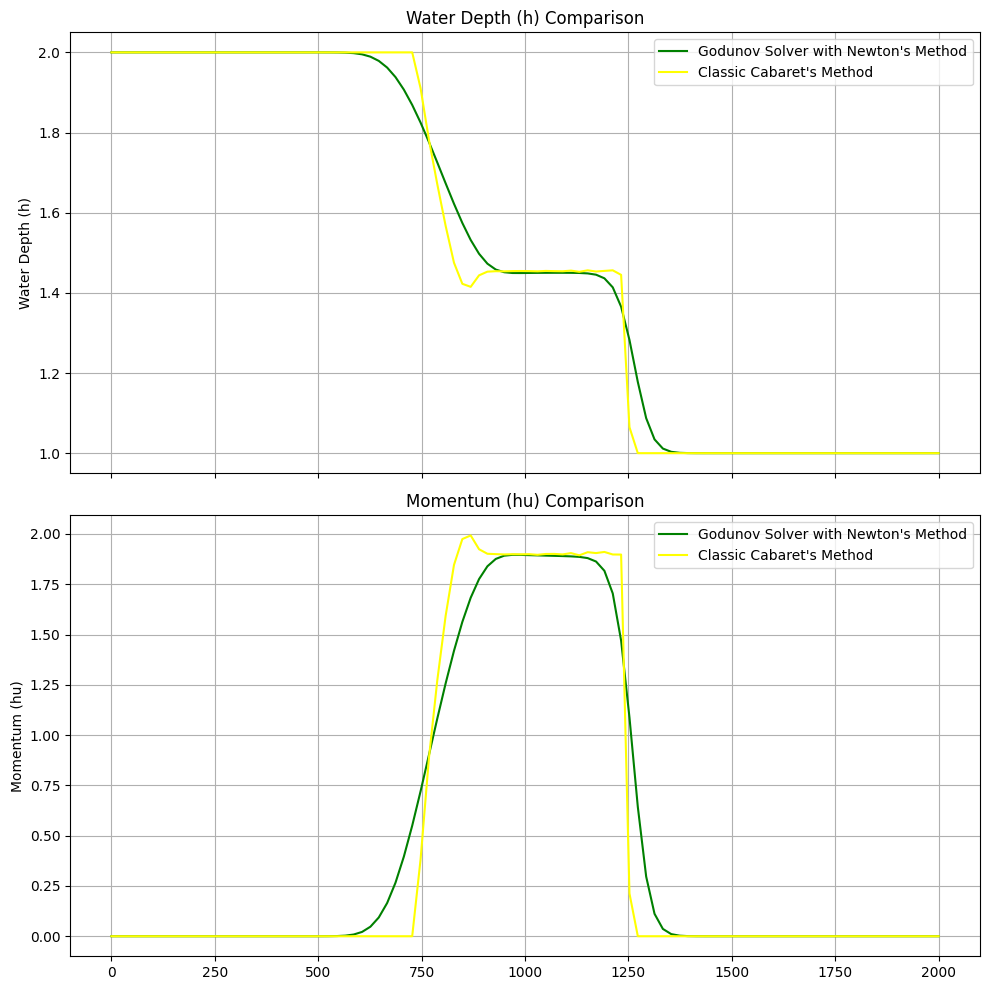

In [14]:
# h_approx, hu_approx = compute(h, hu, solver=0)
# h_iter, hu_iter = compute(h, hu, solver_scheme='godunov_iter')
h_newton, hu_newton = compute(h.copy(), hu.copy(), solver_scheme='godunov_newton')
# print('------------')
h_cabaret, hu_cabaret = compute(new_h.copy(), new_hu.copy(), solver_scheme='cabaret_classic')
# h_cabaret_nn, hu_cabaret_nn = compute(new_h.copy(), new_hu.copy(), solver_scheme='cabaret_nn')
# h_nn, hu_nn = compute(h, hu, solver_scheme='godunov_nn')
# Add a call to the cabaret solver
# h_cabaret, hu_cabaret = compute(h, hu, solver_scheme='cabaret')


# Plot final results using subplots
x = np.linspace(0, L, nx)

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot water depth (h)
# axes[0].plot(x, h_approx, label='Approximate Solve', linestyle='-', color='blue')
# axes[0].plot(x, h_iter, label='Iterative Solver', linestyle='-', color='orange')
axes[0].plot(x, h_newton, label='Godunov Solver with Newton\'s Method', linestyle='-', color='green')
axes[0].plot(x, h_cabaret[::2], label='Classic Cabaret\'s Method', linestyle='-', color='yellow')
# axes[0].plot(x, h_cabaret_nn[::2], label='NN Cabaret\'s Method', linestyle='-', color='blue')
# axes[0].plot(x, h_nn, label='NN', linestyle='-', color='red')
axes[0].set_ylabel('Water Depth (h)')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Water Depth (h) Comparison')

# Plot momentum (hu)
# axes[1].plot(x, hu_approx, label='Approximate Solver', linestyle='-', color='blue')
# axes[1].plot(x, hu_iter, label='Iterative Solver', linestyle='-', color='orange')
axes[1].plot(x, hu_newton, label='Godunov Solver with Newton\'s Method', linestyle='-', color='green')
axes[1].plot(x, hu_cabaret[::2], label='Classic Cabaret\'s Method', linestyle='-', color='yellow')
# axes[1].plot(x, hu_cabaret_nn[::2], label='NN Cabaret\'s Method', linestyle='-', color='xkcd:sky blue')
# axes[1].plot(x, hu_nn, label='NN', linestyle='-', color='red')
axes[1].set_ylabel('Momentum (hu)')
axes[1].legend()
axes[1].grid()
axes[1].set_title('Momentum (hu) Comparison')

# Adjust layout
plt.tight_layout()


# Save the plot as a PNG file
plt.savefig('myplot.png')

plt.show()

In [ ]:
h_cabaret

In [ ]:
riemann_solver_newton(1, 1, 2, -1)

In [ ]:
riemann_solver_newton(2, 1, 4, -1)